<h1> <font color="orange"> Housing Anywhwere Assignment </font> </h1>

<h2> <font color="orange"> Import Libraries </font> </h2>

In [82]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from datetime import datetime as dt
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import json
import pgeocode
from sklearn.preprocessing import LabelEncoder
import lightgbm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import dill
os.chdir(r'C:\Users\gaurav.gund\OneDrive - Grant Thornton Advisory Private Limited\Documents\d_drive\C Drive Backup 2021\Desktop\hackathon\housing_anywhere')



<h4> <font color="orange"> Read Data </font> </h4>

In [50]:
data =pd.read_csv(r'data_science_data_V1.tsv', sep='\t')
data.head(2)

,CREATED_AT,CANCELLATION_POLICY,DEPOSIT,PRICE,FACILITIES_JSON,COSTS_DOC,COUPLES_ALLOWED,KIND,TYPE,ZIP
0,2020-09-10 09:33:40.861 +0000,30d-movein-flexible,1580.0,1580.0,"{""ac"": ""yes"", ""tv"": ""yes"", ""bed"": ""yes"", ""desk...","{""gas-bill"": {""value"": 0, ""required"": true, ""p...",yes,entire_place,apartment,8010.0
1,2021-10-31 07:16:31.161 +0000,strict,NaN,895.0,"{""ac"": ""yes"", ""tv"": ""yes"", ""bed"": null, ""desk""...","{""cleaning-fee"": {""value"": 16900, ""required"": ...",NaN,entire_place,apartment,8003.0


In [6]:
data.shape

(14917, 10)

<h2> <font color="orange"> Exploratory Analysis </font> </h2>

In [7]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14917 entries, 0 to 14916
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CREATED_AT           14917 non-null  object 
 1   CANCELLATION_POLICY  14917 non-null  object 
 2   DEPOSIT              9778 non-null   float64
 3   PRICE                14716 non-null  float64
 4   FACILITIES_JSON      14917 non-null  object 
 5   COSTS_DOC            14865 non-null  object 
 6   COUPLES_ALLOWED      6817 non-null   object 
 7   KIND                 14917 non-null  object 
 8   TYPE                 14917 non-null  object 
 9   ZIP                  14910 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.1+ MB


In [9]:
data.describe()

,DEPOSIT,PRICE,ZIP
count,9778.000000,14716.000000,14910.000000
mean,1652.079923,1181.545927,8017.887525
std,1094.504275,1006.000609,372.914014
min,0.000000,0.000000,8001.000000
25%,650.000000,695.000000,8004.000000
50%,1700.000000,1050.000000,8012.000000
75%,2390.000000,1400.000000,8022.000000
max,14850.000000,59500.000000,40193.000000


<h4> <font color="orange"> Distribution of Price </font> </h4>

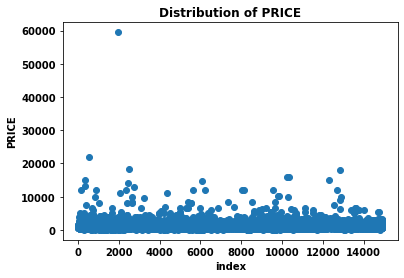

In [8]:
plt.scatter(data.index, data['PRICE'] )
plt.xlabel('index')
plt.ylabel('PRICE')
plt.title('Distribution of PRICE')
plt.show()


<h4> <font color="orange"> Count of observations by year in Created_at </font> </h4> 

In [10]:
pd.to_datetime(data['CREATED_AT']).dt.year.value_counts()


2021    6058
2020    5053
2019    3806
Name: CREATED_AT, dtype: int64

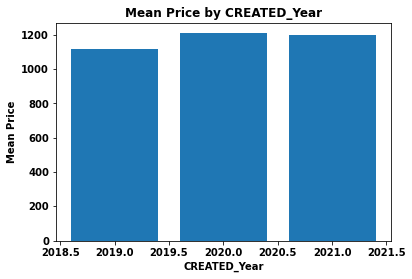

 
Observation: Year does not have any impact on mean price


In [238]:
d2 = data
d2['CREATED_AT']= pd.to_datetime(data['CREATED_AT'])
d2['year'] = d2.CREATED_AT.dt.year
abc1 = d2.groupby(['year'])['PRICE'].mean().reset_index()
abc1.columns = ['CREATED_Year', 'Mean Price']
plt.bar(abc1['CREATED_Year'], abc1['Mean Price'])
plt.title('Mean Price by CREATED_Year')
plt.xlabel('CREATED_Year')
plt.ylabel('Mean Price')
plt.show()

data = data.drop('year', axis = 1)

print(' ')
print('Observation: Year does not have any impact on mean price')

<h4> <font color="orange"> Distribution of Deposit vs Price </font> </h4>

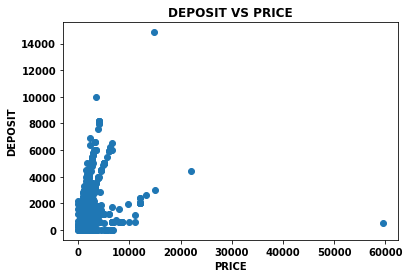

Observation: Moderate positive correlation can be observed in Deposit and Price though there are counter observations


In [13]:
plt.scatter( data['PRICE'], data['DEPOSIT'])
plt.xlabel('PRICE')
plt.ylabel('DEPOSIT')
plt.title('DEPOSIT VS PRICE')
plt.show()
print('Observation: Moderate positive correlation can be observed in Deposit and Price though there are counter observations')

<h4> <font color="orange"> Understanding Cancellation_policy   </font> </h4>

In [20]:
print(data['CANCELLATION_POLICY'].value_counts())
print(' ')
print("Observation: More properties with strict cancellation policy than flexible")

strict                 13505
30d-movein-flexible     1412
Name: CANCELLATION_POLICY, dtype: int64
 
Observation: More properties with strict cancellation policy than flexible


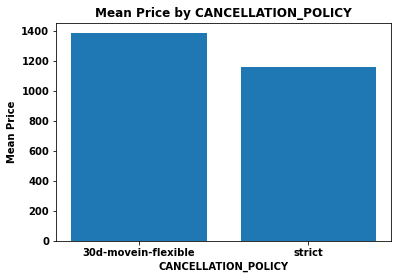

 
Observation: Mean Price is higher for flexible Cancellation policy to cater to extra risks of cancellation 


In [22]:
abc1 = data.groupby(['CANCELLATION_POLICY'])['PRICE'].mean().reset_index()
abc1.columns = ['CANCELLATION_POLICY', 'Mean Price']
plt.bar(abc1['CANCELLATION_POLICY'], abc1['Mean Price'])
plt.title('Mean Price by CANCELLATION_POLICY')
plt.xlabel('CANCELLATION_POLICY')
plt.ylabel('Mean Price')
plt.show()


print(' ')
print('Observation: Mean Price is higher for flexible Cancellation policy to cater to extra risks of cancellation ')


<h4> <font color="orange"> Understanding KIND variable   </font> </h4>

In [24]:
print(data['KIND'].value_counts())
print(' ')
print('Observation: More properties are available entirely followed by private rooms and shared rooms')

entire_place    10670
private_room     4047
shared_room       200
Name: KIND, dtype: int64
 
Observation: More properties are available entirely followed by private rooms and shared rooms


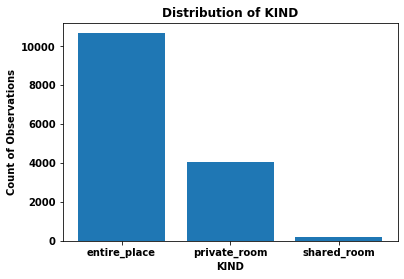

In [25]:
# distribution of KIND
abc = data['KIND'].value_counts().reset_index()
abc.columns = ['KIND', 'Count of Observations']
plt.bar(abc['KIND'], abc['Count of Observations'])
plt.title('Distribution of KIND')
plt.xlabel('KIND')
plt.ylabel('Count of Observations')
plt.show()


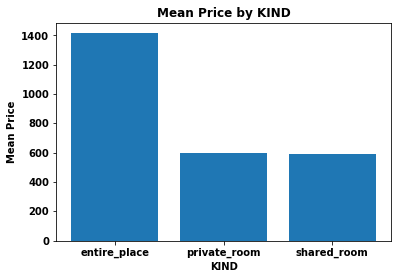

 
Observation: Mean price is higher for entire place followed by private room and shared rooms


In [27]:
# distribution of KIND and price

abc1 = data.groupby(['KIND'])['PRICE'].mean().reset_index()
abc1.columns = ['KIND', 'Mean Price']
plt.bar(abc1['KIND'], abc1['Mean Price'])
plt.title('Mean Price by KIND')
plt.xlabel('KIND')
plt.ylabel('Mean Price')
plt.show()

print(' ')
print('Observation: Mean price is higher for entire place followed by private room and shared rooms')

<h4> <font color="orange">  Understanding Type variable  </font> </h4>

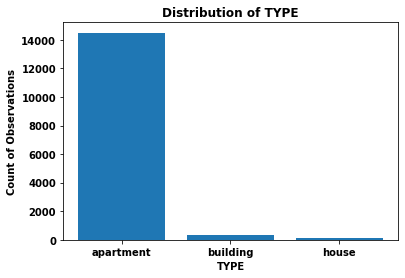

 
Observation: Most properties are of type apartment followed by very few properties of type building or house


In [29]:
# distribution of TYPE
abc = data['TYPE'].value_counts().reset_index()
abc.columns = ['TYPE', 'Count of Observations']
plt.bar(abc['TYPE'], abc['Count of Observations'])
plt.title('Distribution of TYPE')
plt.xlabel('TYPE')
plt.ylabel('Count of Observations')
plt.show()

print(' ')
print('Observation: Most properties are of type apartment followed by very few properties of type building or house')



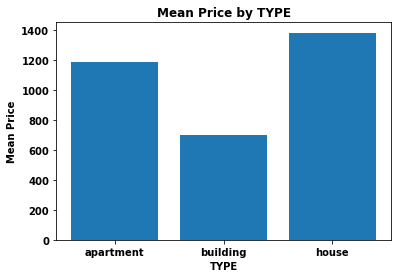

Observation: Contrary to number of properties for each type, the mean price is higher for house followed by apartment and building 


In [31]:
# distribution of TYPE and price

abc1 = data.groupby(['TYPE'])['PRICE'].mean().reset_index()
abc1.columns = ['TYPE', 'Mean Price']
plt.bar(abc1['TYPE'], abc1['Mean Price'])
plt.title('Mean Price by TYPE')
plt.xlabel('TYPE')
plt.ylabel('Mean Price')
plt.show()

print('Observation: Contrary to number of properties for each type, the mean price is higher for house followed by apartment and building ')

<h4> <font color="orange"> Understanding Couples allowed variable   </font> </h4>

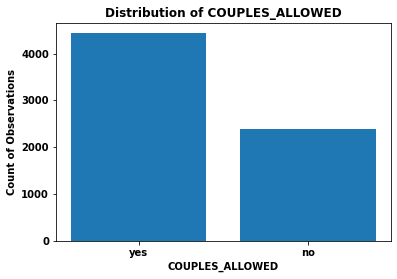

 
Observation: The number of properties that allows Couples are higher than the ones who does not allow couples


In [33]:
# distribution of couples allowed
abc = data['COUPLES_ALLOWED'].value_counts().reset_index()
abc.columns = ['COUPLES_ALLOWED', 'Count of Observations']
plt.bar(abc['COUPLES_ALLOWED'], abc['Count of Observations'])
plt.title('Distribution of COUPLES_ALLOWED')
plt.xlabel('COUPLES_ALLOWED')
plt.ylabel('Count of Observations')
plt.show()
print(' ')
print('Observation: The number of properties that allows Couples are higher than the ones who does not allow couples')

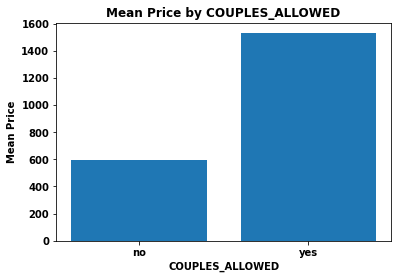

Observation: Mean price is higher for properties that allows Couples


In [35]:
# distribution of couples allowed and price

abc1 = data.groupby(['COUPLES_ALLOWED'])['PRICE'].mean().reset_index()
abc1.columns = ['COUPLES_ALLOWED', 'Mean Price']
plt.bar(abc1['COUPLES_ALLOWED'], abc1['Mean Price'])
plt.title('Mean Price by COUPLES_ALLOWED')
plt.xlabel('COUPLES_ALLOWED')
plt.ylabel('Mean Price')
plt.show()

print('Observation: Mean price is higher for properties that allows Couples')

<h4> <font color="orange"> Distribution of Zip  </font> </h4>

In [49]:
data.ZIP.iloc[0]

'8010.0'

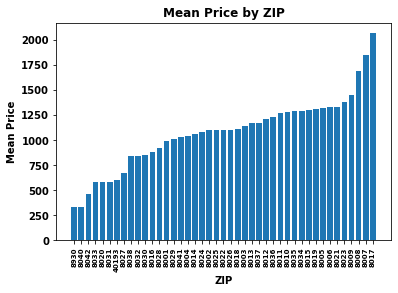

Observation: Mean price is higher for properties in ZIP 8017, 8007 and 8008. There is 1 zip code 40193 which is different


In [60]:
d1 = data
d1 = d1[~d1.ZIP.isnull()]
d1['ZIP'] = d1.ZIP.apply(lambda x: str(int(float(x))))
abc1 = d1.groupby(['ZIP'])['PRICE'].mean().reset_index().sort_values('PRICE')
abc1.columns = ['ZIP', 'Mean Price']
plt.bar(abc1['ZIP'], abc1['Mean Price'])
plt.title('Mean Price by ZIP')
plt.xlabel('ZIP')
plt.xticks(fontsize=7, rotation='vertical')
plt.ylabel('Mean Price')
plt.show()

print('Observation: Mean price is higher for properties in ZIP 8017, 8007 and 8008. There is 1 zip code 40193 which is different')

<h4> <font color="orange"> Understanding Facilities Json variable  </font> </h4>

In [116]:
data['FACILITIES_JSON'].head(3)

0    {"ac": "yes", "tv": "yes", "bed": "yes", "desk...
1    {"ac": "yes", "tv": "yes", "bed": null, "desk"...
2    {"ac": "no", "tv": "yes", "bed": "yes", "desk"...
Name: FACILITIES_JSON, dtype: object

In [115]:
print('Unique Combination of dictionary is :' + str(len(data['FACILITIES_JSON'].value_counts().unique())))

Unique Combination of dictionary is :34


<h4> <font color="orange"> Understanding COSTS DOC variable  </font> </h4>

In [117]:
data['COSTS_DOC'].head(3)

0    {"gas-bill": {"value": 0, "required": true, "p...
1    {"cleaning-fee": {"value": 16900, "required": ...
2    {"water-bill": {"value": 3000, "required": tru...
Name: COSTS_DOC, dtype: object

In [118]:
print('Unique Combination of dictionary is :' + str(len(data['COSTS_DOC'].value_counts().unique())))

Unique Combination of dictionary is :62


<h4> <font color="orange"> Missing Value Check: Data Availability by Variables   </font> </h4>

In [62]:
print(data.isnull().sum(axis= 0))

print(' ')
print('Missing values are observed in Price which is a Target Variable')

CREATED_AT                0
CANCELLATION_POLICY       0
DEPOSIT                5139
PRICE                   201
FACILITIES_JSON           0
COSTS_DOC                52
COUPLES_ALLOWED        8100
KIND                      0
TYPE                      0
ZIP                       7
dtype: int64
 
Missing values are observed in Price which is a Target Variable


<h2> <font color="orange">  Data Split into Train, Test & Validation  </font> </h2>

In [334]:
print('There are missing values and 0  in Target Variable, all those will become test data')
print(' ')
print('Random Sampling is used to further create train and validation data')
print( ' ')
test = data[(data.PRICE.isnull())  | (data.PRICE<=0)]

data1 = data[~((data.PRICE.isnull())  | (data.PRICE<=0))]
train, valid = train_test_split(data1, test_size = 0.2)

print('Dimension of training: ' + str(train.shape))
print('Dimension of test: ' + str(test.shape))
print('Dimension of  validation: ' + str(valid.shape))


There are missing values and 0  in Target Variable, all those will become test data
 
Random Sampling is used to further create train and validation data
 
Dimension of training: (11764, 10)
Dimension of test: (212, 10)
Dimension of  validation: (2941, 10)


<h2> <font color="orange"> User Defined Functions for Data Preparation    </font> </h2>

In [467]:
class MultiColumnLabelEncoder:
    '''Allows encoding multiple Target variables together and transform to DataFrame'''
    
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

    

# function to extract facilities_json

def null_x(x):
    '''Function to fix null values in Facilities json '''
    try:
        if 'null' in x:
            x = x.replace('null', '"'+'null'+ '"')
            return(x)
    except:
        return(np.nan)

def true_false_x(x):
    '''Function to fix true/false values in Facilities json '''
    
    try:
        x = x.replace('true', '"'+'true'+ '"').replace('false', '"'+'false'+ '"')
        return(x)
    except:
        return(np.nan)

def eval_x(x):
    '''Function to apply eval on all the rows of a dataframe '''
    if x:
        try:
            return(eval(x))
        except:
            return(np.nan)
    return(np.nan)

def same_train_test(cols_train, cols_test, test):
    '''Function to ensure train and test has same features'''
    
    # get list of columns not in test
    cols_not_in_test = [i for i in cols_train if i not in cols_test]
    
    # make a column for them with value 0
    if cols_not_in_test:
        for i in cols_not_in_test:
            test[i] = 0
    
    # re-arrange columns based on training data
    test_final = test[cols_train]
    return(test_final)

def remove_missing(x_train1, threshold):
    '''Function to remove missing values given a threshold'''
    list1=[]
    for i in x_train1.columns:
        if x_train1[i].isnull().sum() > 0:
            a = x_train1[i].isnull().sum()*100/x_train1.shape[0]
            if a> threshold:
                list1.append(i)
    x_train_fin = x_train1.drop(list1, axis = 1)
    return(x_train_fin, list1)

<h2> <font color="orange"> Iteration 1: Developing Baseline Model    </font> </h2>

<h3> <font color="orange"> Iteration 1: Feature Engineering and Data Preprocessing on Training Data </font> </h3>

<h4> <font color="orange"> Preprocess Training data   </font> </h4>

In [241]:
# One hot Encode
train_t = pd.get_dummies(train, columns=['CANCELLATION_POLICY', 'COUPLES_ALLOWED', 'KIND', 'TYPE', 'ZIP'], dummy_na = True)

#  remove columns
train_t = train_t.drop(['CREATED_AT', 'FACILITIES_JSON', 'COSTS_DOC'], axis= 1)

# convert columns to numeric
cols = train_t.columns

train_t[cols] = train_t[cols].apply(pd.to_numeric, errors='coerce')

In [242]:
y_t = train_t['PRICE']
x_t = train_t.drop('PRICE', axis = 1)

<h4> <font color="orange">  Missing Value check and Imputation  </font> </h4>

In [243]:
print(x_t.isnull().sum(axis = 0))

print(' ')
print('Observation: Missing values in Deposit')

DEPOSIT                                    4031
CANCELLATION_POLICY_30d-movein-flexible       0
CANCELLATION_POLICY_strict                    0
CANCELLATION_POLICY_nan                       0
COUPLES_ALLOWED_no                            0
COUPLES_ALLOWED_yes                           0
COUPLES_ALLOWED_nan                           0
KIND_entire_place                             0
KIND_private_room                             0
KIND_shared_room                              0
KIND_nan                                      0
TYPE_apartment                                0
TYPE_building                                 0
TYPE_house                                    0
TYPE_nan                                      0
ZIP_8001.0                                    0
ZIP_8002.0                                    0
ZIP_8003.0                                    0
ZIP_8004.0                                    0
ZIP_8005.0                                    0
ZIP_8006.0                              

<h4> <font color="orange"> Missing Value Imputation   </font> </h4>

In [244]:
imp_mean1 = IterativeImputer(random_state=0, max_iter = 100)
x_t_imp = imp_mean1.fit_transform(x_t)

<h4> <font color="orange"> Preprocess Validation Data   </font> </h4>

In [245]:
# One hot Encode

val_t = pd.get_dummies(valid, columns=['CANCELLATION_POLICY', 'COUPLES_ALLOWED', 'KIND', 'TYPE', 'ZIP'], dummy_na = True)

#  remove columns
val_t = val_t.drop(['CREATED_AT', 'FACILITIES_JSON', 'COSTS_DOC'], axis= 1)

# convert columns to numeric
cols =val_t.columns

val_t[cols] = val_t[cols].apply(pd.to_numeric, errors='coerce')

In [246]:

y_v = val_t['PRICE']
x_v = val_t.drop('PRICE', axis = 1)

<h4> <font color="orange">  Same columns in Training and Validation data  </font> </h4>

In [247]:
x_v= same_train_test(list(x_t.columns), list(x_v.columns), x_v)
x_t.shape, x_v.shape

((11764, 59), (2941, 59))

<h4> <font color="orange">  Impute missing value on Validation data  </font> </h4>

In [248]:
x_v_imp = imp_mean1.transform(x_v)

<h4> <font color="orange">  Random Forest Model  </font> </h4>

In [267]:
rgb_base = RandomForestRegressor(n_estimators = 800, max_features = 0.7, max_samples = 0.9, oob_score= True)

In [268]:
rgb_base.fit(x_t_imp, y_t)

RandomForestRegressor(max_features=0.7, max_samples=0.9, n_estimators=800,
                      oob_score=True)

In [269]:
pred = rgb_base.predict(x_v_imp)
print('MAE on Validation Data: ' + str(mean_absolute_error(y_v, pred)))

MAE on Validation Data: 236.8650364242463


In [270]:
print('MAE on Training Data: ' + str(mean_absolute_error(y_t, rgb_base.predict(x_t_imp))))

MAE on Training Data: 160.41801260284058


<h4> <font color="orange">  Random Forest Model: Results Analysis  </font> </h4>

In [271]:
df_base = pd.DataFrame()
df_base['actual'] = y_v
df_base['predicted'] = pred
df_base['residuals'] = df_base['actual'] - df_base['predicted']
conditions  = [ df_base['residuals'] <= -300, (df_base['residuals'] >= -300) & (df_base['residuals']<= 300), df_base['residuals'] >= 300 ]
choices     = [ "underestimation", 'moderate', 'overestimation' ]

df_base["infer"] = np.select(conditions, choices, default=np.nan)

print(df_base['infer'].value_counts(normalize=True))
print(' ')
print('Observations: Almost 81% of data falls in the range of +- 300, there is 11% of data where underestimation is happening followed by 7% of data with Overestimation')


moderate           0.812989
underestimation    0.107106
overestimation     0.079905
Name: infer, dtype: float64
 
Observations: Almost 81% of data falls in the range of +- 300, there is 11% of data where underestimation is happening followed by 7% of data with Overestimation


<h2> <font color="orange">  Observations on Random Forest Model: Iteration first </font> </h2>

<li> Base model without taking into consideration Facilities and Costs is built </li>
<li> Reason for not including Facilities and Costs in base model is the sparse variables which might introduce missing values </li>
<li> One-hot encoding is done for all other variables including ZIP code since latitude and longitude information was the same across all ZIP codes</li>
<li> Tree-based Random Forest (Bagging) is used after trying Lightgbm (Boosting)(MAE of 265 was achieved) based on the lower MAE on validation </li> 
<li> Error Analysis is done to understand model tendency to predict </li>

<h2> <font color="orange">  Iteration 2: Developing Model with Facilities and Costs included </font> </h2>

<h4> <font color="orange"> Applying function and preprocess variables in training data   </font> </h4>

In [335]:
# convert CREATED_AT into Datetime field
train['CREATED_AT'] = pd.to_datetime(train['CREATED_AT'])

In [336]:
train.head(2)

,CREATED_AT,CANCELLATION_POLICY,DEPOSIT,PRICE,FACILITIES_JSON,COSTS_DOC,COUPLES_ALLOWED,KIND,TYPE,ZIP
4508,2021-01-16 07:17:10.756000+00:00,strict,2190.0,1095.0,"{""ac"": ""yes"", ""tv"": ""yes"", ""bed"": null, ""desk""...","{""gas-bill"": {""value"": 0, ""required"": true, ""p...",NaN,entire_place,apartment,8014.0
4525,2020-12-22 10:32:51.768000+00:00,strict,NaN,3002.0,"{""ac"": ""yes"", ""tv"": ""yes"", ""bed"": ""yes"", ""desk...","{""gas-bill"": {""value"": 0, ""required"": true, ""p...",yes,entire_place,apartment,8014.0


<h4> <font color="orange"> Extract FACILITIES & COSTS and combine with train data  </font> </h4>

In [337]:
#Extracting data from FACILITIES_JSON AND COSTS_DOC
train['FACILITIES_JSON'] = train['FACILITIES_JSON'].apply(lambda x: null_x(x))

train['FACILITIES_JSON'] = train['FACILITIES_JSON'].apply(lambda x: eval_x(x) )
train['COSTS_DOC'] = train['COSTS_DOC'].apply(lambda x: true_false_x(x) )
train['COSTS_DOC'] = train['COSTS_DOC'].apply(lambda x: eval_x(x) )
t2 = pd.json_normalize(train['COSTS_DOC'])
t1 = pd.json_normalize(train['FACILITIES_JSON'])

In [338]:
t1.head(2)

,ac,tv,bed,desk,lock,wifi,dryer,closet,garden,toilet,...,housemates_gender,internet_included,water_cost_included,electricity_included,registration_possible,wheelchair_accessible,shed,balcony,bedroom,terrace
0,yes,yes,null,null,no,yes,null,yes,no,private,...,null,yes,yes,yes,yes,yes,NaN,NaN,NaN,NaN
1,yes,yes,yes,yes,yes,yes,yes,yes,no,private,...,null,yes,yes,yes,yes,no,NaN,NaN,NaN,NaN


In [339]:
numeric_t1 = ['total_size', 'bedroom_count', 'bedroom_size']

numeric_t2= ['security-deposit.value', 'administration-fee.value', 'cleaning-fee.value', 'utility-bills.value','gas-bill.value', 'water-bill.value', 'internet-bill.value', 'electricity-bill.value', 'late-move-in.value', 'cleaning-service.value', 'administration-fee.calculationRule.value', 'towels-and-bedding.value', 'end-early-fee.value', 'final-cleaning.value', 'overnight-guests.value', 'other-additional-costs.value', 'parking.value', 'broadcasting-bill.value', 'early-move-in.value', 'early-move-out.value', 'other-deposit.value', 'gym.value', 'full-board.value', 'half-board.value', 'late-move-out.value', 'other-optional-costs.value', 'towel-deposit.value', 'bedding-deposit.value' ]



In [340]:
# combine all data
t1.index = train.index.values
t2.index = train.index.values
train1 = pd.concat([train, t1, t2] , axis= 1)

In [341]:
train1.shape

(11764, 219)

In [342]:
cols_train_before = train1.columns

le_cols = list(set(train1.columns)- set(train.columns)-set(numeric_t1)-set(numeric_t2))

In [471]:
le_cols

['broadcasting-bill.payableBy',
 'internet-bill.refundable',
 'towel-deposit.refundable',
 'other-additional-costs.refundable',
 'terrace',
 'towel-deposit.payableBy',
 'tenant_status',
 'full-board.refundable',
 'shed',
 'towels-and-bedding.required',
 'allergy_friendly',
 'parking.payableBy',
 'towel-deposit.payableAt',
 'broadcasting-bill.isEstimated',
 'water-bill.payableAt',
 'gas-bill.payableBy',
 'gas_cost_included',
 'towels-and-bedding.payableAt',
 'half-board.payableBy',
 'other-deposit.required',
 'bedroom',
 'water-bill.payableBy',
 'internet-bill.required',
 'half-board.isEstimated',
 'bathroom',
 'water-bill.isEstimated',
 'other-deposit.payableAt',
 'bedding-deposit.required',
 'water-bill.refundable',
 'utility-bills.required',
 'cleaning-service.refundable',
 'bedding-deposit.isEstimated',
 'electricity-bill.isEstimated',
 'parking.required',
 'kitchenware',
 'internet_included',
 'administration-fee.isEstimated',
 'late-move-in.refundable',
 'lroom_furniture',
 'towel

<h4> <font color="orange"> Convert Categorical to Numeric variables </font> </h4>

In [468]:
mle = MultiColumnLabelEncoder(columns = le_cols)

In [470]:
train1.to_csv(r'train1.csv', index = False)

In [469]:
train2 = mle.fit_transform(train1)

AttributeError: 'list' object has no attribute 'shape'

<h4> <font color="orange"> One hot encode variables </font> </h4>

In [345]:
# one hot encode variables

train3 = pd.get_dummies(train2, columns=['CANCELLATION_POLICY', 'COUPLES_ALLOWED', 'KIND', 'TYPE', 'ZIP'], dummy_na = True)


In [346]:
#  remove columns
train3 = train3.drop(['CREATED_AT', 'FACILITIES_JSON', 'COSTS_DOC'], axis= 1)

cols = train3.columns

train3[cols] = train3[cols].apply(pd.to_numeric, errors='coerce')

In [347]:
train3.shape

(11764, 269)

In [348]:
cols_train = train3.columns

<h4> <font color="orange"> Missing value check </font> </h4>

In [349]:
var = []
val=[]
for i in train3.columns:
    if train3[i].isnull().sum() > 0:
        val.append(train3[i].isnull().sum()*100/train3.shape[0])
        var.append(i)
miss_data = pd.DataFrame({'variable': var, 'missing': val})
miss_data = miss_data.sort_values('missing', ascending = False)
print(miss_data)
print(' ')
print('Observations: Multiple variables with 99% missig values can be observed')

                                    variable    missing
31                       towel-deposit.value  99.991499
30                     bedding-deposit.value  99.982999
24                       late-move-out.value  99.982999
25                      early-move-out.value  99.940496
23                       early-move-in.value  99.914995
22                       end-early-fee.value  99.914995
14                other-optional-costs.value  99.906494
29                   broadcasting-bill.value  99.889493
26                          half-board.value  99.829990
21                       other-deposit.value  99.804488
28                          full-board.value  99.761986
27                                 gym.value  99.753485
17                      final-cleaning.value  99.549473
18                             parking.value  99.362462
20              other-additional-costs.value  98.996940
13                    overnight-guests.value  98.342401
16                  towels-and-bedding.value  96

In [350]:
y_train = train3.PRICE
x_train1 = train3.drop('PRICE', axis = 1)


<h4> <font color="orange"> Remove columns with higher missing values  </font> </h4>

In [374]:
x_train3 , cols_remove= remove_missing(x_train1, 41)


In [375]:
x_train3.shape

(11764, 242)

In [376]:
'DEPOSIT' in x_train3.columns

True

In [377]:
var = []
val=[]
for i in x_train3.columns:
    if x_train3[i].isnull().sum() > 0:
        val.append(x_train3[i].isnull().sum()*100/x_train3.shape[0])
        var.append(i)
miss_data = pd.DataFrame({'variable': var, 'missing': val})
miss_data = miss_data.sort_values('missing', ascending = False)
print(miss_data)
print(' ')
print('Observations: Multiple variables with 99% missig values can be observed')

                   variable    missing
3       utility-bills.value  40.266916
0                   DEPOSIT  34.673580
5  administration-fee.value  31.060864
1                total_size  22.568854
2             bedroom_count  16.312479
4    security-deposit.value   8.568514
 
Observations: Multiple variables with 99% missig values can be observed


<h4> <font color="orange"> Imputation of Missing Values </font> </h4>

In [380]:
imp_mean2 = IterativeImputer(max_iter=40, tol=0.001, 
                                 n_nearest_features=10, initial_strategy='median')

x_train3_i =imp_mean2.fit_transform(x_train3)

In [381]:
x_train3_imp = pd.DataFrame(x_train3_i, columns = x_train3.columns,index= x_train3.index)

<h4> <font color="orange"> Random Forest on complete training data </font> </h4>

In [382]:
rgb1 = RandomForestRegressor(n_estimators = 500, max_features = 0.7, max_samples = 0.9, oob_score= True)

In [384]:
rgb1.fit(x_train3_imp, y_train)

RandomForestRegressor(max_features=0.7, max_samples=0.9, n_estimators=500,
                      oob_score=True)

<h4> <font color="orange"> Feature Importance </font> </h4>

In [385]:
feat_importances = pd.Series(rgb1.feature_importances_, index=x_train3_imp.columns)
feat_importances.nlargest(50)

administration-fee.value          0.113901
utility-bills.value               0.109264
security-deposit.value            0.105038
total_size                        0.086167
KIND_entire_place                 0.075117
DEPOSIT                           0.049940
cleaning_private                  0.036319
flooring                          0.027942
basement                          0.021074
heating                           0.020760
bedroom_count                     0.017689
registration_possible             0.016628
ZIP_8003.0                        0.014688
KIND_private_room                 0.012457
tenant_status                     0.011019
play_music                        0.010302
dryer                             0.010223
administration-fee.payableAt      0.010065
parking                           0.009835
administration-fee.required       0.009760
garden                            0.009409
dishwasher                        0.008881
cleaning_common                   0.008849
animal_allo

In [386]:
imp_val = [feat_importances.nlargest(i).sum() for i in range(feat_importances.shape[0])]

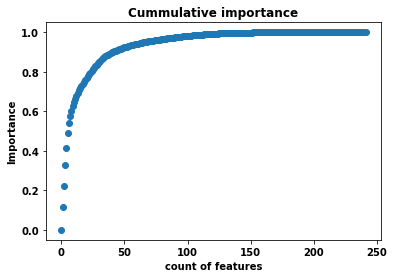

 
Observations: Based on the plot, 100 features can be a good count


In [387]:
plt.scatter(range(0, feat_importances.shape[0]), imp_val)
plt.title('Cummulative importance')
plt.ylabel('Importance')
plt.xlabel('count of features')
plt.show()

print(' ')
print('Observations: Based on the plot, 50 features can be a good count since importance reaches 92%')

In [395]:
important_cols = feat_importances.nlargest(50).index

In [396]:
x_train3_imp_mod = x_train3_imp[important_cols]

In [397]:
x_train3_imp_mod.shape

(11764, 50)

<h4> <font color="orange">Random Forest Training with 50 Important Features </font> </h4>

In [413]:
rgb2 = RandomForestRegressor(n_estimators = 800, max_features = 0.8, max_samples = 0.9, oob_score= True)

In [414]:
rgb2.fit(x_train3_imp_mod, y_train)

RandomForestRegressor(max_features=0.8, max_samples=0.9, n_estimators=800,
                      oob_score=True)

<h4> <font color="orange"> Preprocess Validation data </font> </h4>

In [402]:
def preprocess_test(test, mle,  cols_train, cols_train_before, cols_remove, imp_mean2, important_cols):
    '''Function to input test data and convert it into data ready for Prediction'''

    # convert to datetime
    test['CREATED_AT'] = pd.to_datetime(test['CREATED_AT'])

    test['FACILITIES_JSON'] = test['FACILITIES_JSON'].apply(lambda x: null_x(x))
    test['FACILITIES_JSON'] = test['FACILITIES_JSON'].apply(lambda x: eval_x(x) )
    test['COSTS_DOC'] = test['COSTS_DOC'].apply(lambda x: true_false_x(x) )
    test['COSTS_DOC'] = test['COSTS_DOC'].apply(lambda x: eval_x(x) )
    print('t2.....')
    t2 = pd.json_normalize(test['COSTS_DOC'])
    t1 = pd.json_normalize(test['FACILITIES_JSON'])
    t1.index = test.index.values
    t2.index = test.index.values
    print('Concatenation')
    test1 = pd.concat([test, t1, t2] , axis= 1)
    print('11111')
    cols_test_before = test1.columns
    test2 = same_train_test(cols_train_before, cols_test_before, test1)
    test2 = mle.transform(test2)
    test3 = pd.get_dummies(test2, columns=['CANCELLATION_POLICY', 'COUPLES_ALLOWED', 'KIND', 'TYPE', 'ZIP'], dummy_na = True)
  
#  remove columns
    test3 = test3.drop(['CREATED_AT', 'FACILITIES_JSON', 'COSTS_DOC'], axis= 1)
    cols_test = test3.columns
    test4 = same_train_test(cols_train, cols_test, test3)
    cols = test4.columns
    test4[cols] = test4[cols].apply(pd.to_numeric, errors='coerce')
    test4 = test4.drop(cols_remove, axis = 1)
    y_test = test4.PRICE
    x_test = test4.drop('PRICE', axis = 1)
    x_test_i = imp_mean2.transform(x_test)
    x_test_imp = pd.DataFrame(x_test_i, columns= x_test.columns , index= x_test.index)
    x_test_imp_mod = x_test_imp[important_cols]

    return(x_test_imp_mod, y_test)


In [404]:
valid_final = preprocess_test(valid, mle, cols_train, cols_train_before, cols_remove, imp_mean2, important_cols)

t2.....
Concatenation
11111


<h4> <font color="orange">Prediction on Validtion Data </font> </h4>

In [415]:
predict123= rgb2.predict(valid_final[0])
print(mean_absolute_error(valid_final[1], predict123))
print(mean_absolute_error(y_train, rgb2.predict(x_train3_imp_mod)))



128.01168231928273
51.34821483059873


<h4> <font color="orange">Error Analysis </font> </h4>

In [460]:
df_first = pd.DataFrame()
df_first['actual'] = valid_final[1]
df_first['predicted'] = predict123
df_first['residuals'] = df_first['actual'] - df_first['predicted']
conditions  = [ df_first['residuals'] <= -300, (df_first['residuals'] >= -300) & (df_first['residuals']<= 300), df_first['residuals'] >= 300 ]
choices     = [ "underestimation", 'moderate', 'overestimation' ]

df_first["infer"] = np.select(conditions, choices, default=np.nan)

print(df_first['infer'].value_counts(normalize=True))
print(' ')
print('Observations: Almost 91% of data falls in the range of +- 300, there is 6% of data where underestimation is happening followed by 3% of data with Overestimation')


moderate           0.906494
underestimation    0.064264
overestimation     0.029242
Name: infer, dtype: float64
 
Observations: Almost 91% of data falls in the range of +- 300, there is 6% of data where underestimation is happening followed by 3% of data with Overestimation


<h2> <font color="orange">Observations : Iteration 2 </font> </h2>

<li> Random Forest model with Facilities and Costs are developed </li>
<li> Columns with very high missing values are removed </li>
<li> Nearest Neighbor based imputation is used to impute missing values </li>
<li> Random Forest based Importance is used to reduce number of features from 242 to 50 </li>
<li> This approach led to an improvement from Baseline model by over 108 units in MAE </li>

<h2> <font color="orange">Save models</font> </h2>

In [423]:

# with open('rgb_base', 'wb') as f:
#     dill.dump(rgb_base, f)
    
# with open('rgb2', 'wb') as f:
#     dill.dump(rgb2, f)
    
# with open('rgb1', 'wb') as f:
#     dill.dump(rgb1, f)
    
# with open('mle', 'wb') as f:
#     dill.dump(mle, f)
    
# with open('imp_mean1', 'wb') as f:
#     dill.dump(imp_mean1, f)
    
# with open('imp_mean2', 'wb') as f:
#     dill.dump(imp_mean2, f)
    


In [427]:
# with open('cols_train', 'wb') as f:
#     dill.dump(cols_train, f)

# with open('cols_train_before', 'wb') as f:
#     dill.dump(cols_train_before, f)
    
# with open('important_cols', 'wb') as f:
#     dill.dump(important_cols, f)
    
# with open('cols_remove', 'wb') as f:
#     dill.dump(cols_remove, f)

In [431]:
# valid.to_csv('validation.csv', index= False)

In [443]:
# train.to_csv(r'train.csv', index= False)
# valid.to_csv(r'valid.csv', index = False)
# test.to_csv(r'test.csv', index = False)

In [461]:
valid.shape, df_first.shape

((2941, 10), (2941, 4))

In [463]:

a= pd.concat([valid, df_first ], axis = 1)

In [466]:
#a.to_csv(r'results.csv', index = False)